# Karim Kuserbaev

## Funcs

In [81]:
def get_df_low(code: int):
    train_df = pd.read_parquet(f"../data/interim/train_data_lm_{code}.pqt")
    test_df = pd.read_parquet(f"../data/interim/test_data_lm_{code}.pqt")

    cat_cols = [
        "channel_code", "city", "city_type",
        "okved", "segment", "start_cluster",
        "index_city_code", "ogrn_month", "ogrn_year",
    ]

    train_df[cat_cols] = train_df[cat_cols].astype("category")
    test_df[cat_cols] = test_df[cat_cols].astype("category")

    df = pd.concat([train_df, test_df], ignore_index=True)
    return df



def get_feature_description():
  feature_description = pd.read_excel("../data/feature_description.xlsx") # import feature_description to merge description
  feature_description.columns =  ['col_name', 'description', 'type']
  return feature_description



def cat_column_summary(df):
    """Для категорий всех столбцов"""
    df = df.select_dtypes(exclude="number")
    summary_data = []

    for col_name in df.columns:
        col_dtype = df[col_name].dtype
        num_of_nulls = df[col_name].isnull().sum()
        num_of_non_nulls = df[col_name].notnull().sum()
        num_of_distinct_values = df[col_name].nunique()

        if num_of_distinct_values <= 10:
            distinct_values_counts = df[col_name].value_counts().to_dict()
        else:
            top_10_values_counts = df[col_name].value_counts().head(10).to_dict()
            distinct_values_counts = {k: v for k, v in sorted(top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}

        summary_data.append({
            'col_name': col_name,
            'col_dtype': col_dtype,
            'num_of_nulls': num_of_nulls,
            'num_of_non_nulls': num_of_non_nulls,
            'num_of_distinct_values': num_of_distinct_values,
            'distinct_values_counts': distinct_values_counts
        })


    summary_df = pd.DataFrame(summary_data)
    summary_df_with_fd = pd.merge(summary_df, feature_description, on='col_name', suffixes=('_left', '_right'), how='left')

    return summary_df_with_fd

def num_column_summary(df):
    """Для численных всех столбцов"""

    df = df.select_dtypes(include="number")
    summary_data = []

    for col_name in df.columns:
        col_dtype = df[col_name].dtype
        num_of_nulls = df[col_name].isnull().sum()
        num_of_non_nulls = df[col_name].notnull().sum()
        num_of_distinct_values = df[col_name].nunique()
        mean = df[col_name].mean()
        std = df[col_name].std()
        min_val = df[col_name].min()
        q25 = df[col_name].quantile(0.25)
        q50 = df[col_name].quantile(0.50)
        q75 = df[col_name].quantile(0.75)
        max_val = df[col_name].max()


        if num_of_distinct_values <= 10:
            distinct_values_counts = df[col_name].value_counts().to_dict()
        else:
            top_10_values_counts = df[col_name].value_counts().head(10).to_dict()
            distinct_values_counts = {k: v for k, v in sorted(top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}

        summary_data.append({
            'col_name': col_name,
            'col_dtype': col_dtype,
            'num_of_nulls': num_of_nulls,
            'num_of_non_nulls': num_of_non_nulls,
            'num_of_distinct_values': num_of_distinct_values,
            'mean': mean,
            'std': std,
            'min': min_val,
            'q25': q25,
            'q50': q50,
            'q75': q75,
            'max': max_val,
            'distinct_values_counts': distinct_values_counts

        })




    summary_df = pd.DataFrame(summary_data)
    summary_df_with_fd = pd.merge(summary_df, feature_description, on='col_name', suffixes=('_left', '_right'), how='left')

    return summary_df_with_fd
# Пустые значения


def get_nan_3_month_df(df):

  nan_3_month_df = pd.DataFrame(df['id'].unique(), columns=['id'])

  for column in df.columns[1:]:
    start_time = time.time()
    result = df.groupby('id')[column].apply(
        lambda x: x.isna().all()).reset_index()
    nan_3_month_df = pd.merge(
        nan_3_month_df, result, on='id', suffixes=('_left', '_right'), how='left')
    end_time = time.time()
  return nan_3_month_df



def process_nan(x):
    try:
        x = x.dropna(
        ).values[-1] if x.isna().any() and not x.isna().all() else np.nan
        return x
    except:
        print(x)
        return x




def get_nan_values_3_month_df(df):

  nan_3_month_df = pd.DataFrame(df['id'].unique(), columns=['id'])
  for column in df.columns[1:]:
    start_time = time.time()
    result = df.groupby('id')[column].apply(
        lambda x: process_nan(x)).reset_index()
    nan_3_month_df = pd.merge(
        nan_3_month_df, result, on='id', how='left')
    end_time = time.time()
    print(f"{column} {end_time - start_time}")
  return nan_3_month_df



def plt_null_df(df):

    plt.figure(figsize=(15, 8))

    plt.imshow(df, aspect="auto", interpolation="nearest", cmap="viridis")

    plt.xticks(range(len(df.columns)), df.columns, rotation='vertical')

    plt.xlabel("Column Number")
    plt.ylabel("Sample Number")

    plt.show()




# Корреляция
def plt_corr_df(df):

  corr_df = df.select_dtypes(include='number').corr().abs()

  plt.figure(figsize=(20, 15))
  dataplot = sns.heatmap(corr_df,
                        cmap="YlGnBu", annot=True, fmt=".1f",
                        annot_kws={'size': 5})
  plt.show()

def get_columns_corr(df, p: int):
    corr_df = df.select_dtypes(include='number').corr().abs()
    c1 = corr_df.unstack()

    c1_sorted = c1.sort_values(ascending=True)
    columns_above = {(col1, col2): c1_sorted[col1, col2] for col1, col2 in c1_sorted.index if c1_sorted[col1, col2] > p and col1 != col2}

    return dict(sorted(columns_above.items(), key=lambda item: item[1], reverse=True))

## Импорт библиотек и настройки

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
!pip install catboost

In [100]:
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import os

from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier, Pool
import catboost
from catboost import *
from catboost import datasets


import numpy as np
import time
import json

import pandas as pd
pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option('display.max_rows', 93)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

import warnings
from sklearn.utils import resample


# Отключить все предупреждения временно
warnings.filterwarnings("ignore")

# Ваш код, вызывающий предупреждение о переполнении

# Включить предупреждения обратно
# warnings.filterwarnings("default")


import matplotlib.pyplot as plt

from sklearn.ensemble import StackingClassifier, RandomForestClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

In [ ]:
!pip freeze | grep "numpy\|pandas\|lightgbm\|scikit-learn"

In [3]:
pd.options.display.max_rows = 93
pd.options.display.max_columns = 93

## Загрузка данных

In [82]:
df = pd.read_parquet("/kaggle/input/df-restore-cal-avg-start-cluster-3-pqt/df_restore_cal_avg_start_cluster_3.pqt")
df = pd.read_parquet("/kaggle/input/df-restore-cal-avg-start-cluster-3-pqt/df_restore_cal_avg_start_cluster_3.pqt")

df_org = pd.read_parquet("/kaggle/input/df-for-alfa-hak/df_restore_cat_avg.pqt")

In [5]:
df

,id,avg_a_oper_1m_month_1,avg_a_oper_1m_month_2,avg_a_oper_1m_month_3,avg_a_oper_3m_month_1,avg_a_oper_3m_month_2,avg_a_oper_3m_month_3,avg_b_oper_1m_month_1,avg_b_oper_1m_month_2,avg_b_oper_1m_month_3,avg_b_oper_3m_month_1,avg_b_oper_3m_month_2,avg_b_oper_3m_month_3,avg_c_oper_1m_month_1,avg_c_oper_1m_month_2,avg_c_oper_1m_month_3,avg_c_oper_3m_month_1,avg_c_oper_3m_month_2,avg_c_oper_3m_month_3,avg_cred_d_oper_1m_month_1,avg_cred_d_oper_1m_month_2,avg_cred_d_oper_1m_month_3,avg_cred_d_oper_3m_month_1,avg_cred_d_oper_3m_month_2,avg_cred_d_oper_3m_month_3,avg_cred_e_oper_1m_month_1,avg_cred_e_oper_1m_month_2,avg_cred_e_oper_1m_month_3,avg_cred_e_oper_3m_month_1,avg_cred_e_oper_3m_month_2,avg_cred_e_oper_3m_month_3,avg_cred_f_oper_1m_month_1,avg_cred_f_oper_1m_month_2,avg_cred_f_oper_1m_month_3,avg_cred_f_oper_3m_month_1,avg_cred_f_oper_3m_month_2,avg_cred_f_oper_3m_month_3,avg_cred_g_oper_1m_month_1,avg_cred_g_oper_1m_month_2,avg_cred_g_oper_1m_month_3,avg_cred_g_oper_3m_month_1,avg_cred_g_oper_3m_month_2,avg_cred_g_oper_3m_month_3,avg_cred_h_oper_1m_month_1,avg_cred_h_oper_1m_month_2,avg_cred_h_oper_1m_month_3,...,cnt_deb_f_oper_3m_month_3,cnt_deb_g_oper_1m_month_1,cnt_deb_g_oper_1m_month_2,cnt_deb_g_oper_1m_month_3,cnt_deb_g_oper_3m_month_1,cnt_deb_g_oper_3m_month_2,cnt_deb_g_oper_3m_month_3,cnt_deb_h_oper_1m_month_1,cnt_deb_h_oper_1m_month_2,cnt_deb_h_oper_1m_month_3,cnt_deb_h_oper_3m_month_1,cnt_deb_h_oper_3m_month_2,cnt_deb_h_oper_3m_month_3,ft_registration_date_month_1,ft_registration_date_month_2,ft_registration_date_month_3,ogrn_days_end_month_month_1,ogrn_days_end_month_month_2,ogrn_days_end_month_month_3,ogrn_days_end_quarter_month_1,ogrn_days_end_quarter_month_2,ogrn_days_end_quarter_month_3,ogrn_month_month_1,ogrn_month_month_2,ogrn_month_month_3,ogrn_year_month_1,ogrn_year_month_2,ogrn_year_month_3,okved_month_1,okved_month_2,okved_month_3,segment_month_1,segment_month_2,segment_month_3,start_cluster_month_1,start_cluster_month_2,start_cluster_month_3,sum_of_paym_1y_month_1,sum_of_paym_1y_month_2,sum_of_paym_1y_month_3,sum_of_paym_2m_month_1,sum_of_paym_2m_month_2,sum_of_paym_2m_month_3,sum_of_paym_6m_month_1,sum_of_paym_6m_month_2,sum_of_paym_6m_month_3
0,0,-0.4528,-0.4528,-0.4528,-0.9934,-0.9934,-0.9934,-0.0693,-0.0693,-0.0693,-0.0579,-0.0579,-0.0579,-0.1877,-0.1877,-0.1877,-0.1246,-0.1246,-0.1246,-0.2868,-0.2868,-0.2868,-0.2751,-0.2751,-0.2751,0.5789,0.1088,0.1704,0.5045,0.4758,0.3247,-0.1166,-0.1166,-0.1166,-0.1032,-0.1032,-0.1032,0.4415,-0.0957,-0.1334,0.1964,0.1318,0.0355,1.8045,0.6478,0.8779,...,0.2861,0.5139,0.5139,0.5139,0.4581,0.4581,0.4581,0.6541,0.6528,0.6534,0.5536,0.5519,0.5510,2.4522,2.4699,2.4859,-0.4886,-0.4886,-0.4886,-0.1351,-0.1351,-0.1351,ogrn_month_0,ogrn_month_0,ogrn_month_0,ogrn_year_1,ogrn_year_1,ogrn_year_1,okved_30,okved_30,okved_30,segment_1,segment_1,segment_1,"{α, γ}","{α, γ}","{α, γ}",0.5115,0.4864,0.4805,0.9423,0.6457,0.4036,0.5360,0.5364,0.6132
1,1,-0.4528,-0.4528,-0.4528,-0.9934,-0.9934,-0.9934,-0.0693,-0.0693,-0.0693,-0.0579,-0.0579,-0.0579,-0.1877,-0.1877,-0.1877,-0.1246,-0.1246,-0.1246,-0.2868,-0.2868,-0.1764,-0.2751,-0.2751,-0.2387,0.1295,-0.0411,-0.0101,0.2257,0.0689,0.0312,-0.1166,-0.1166,-0.1166,-0.1032,-0.1032,-0.1032,-0.0824,-0.1219,-0.0719,-0.0260,-0.0253,-0.0205,-0.2904,-0.2176,-0.1917,...,0.2861,0.5152,0.5165,0.5152,0.4589,0.4598,0.4598,0.6611,0.6580,0.6617,0.5671,0.5599,0.5608,0.1740,0.1918,0.2078,0.3243,0.3243,0.3243,1.2587,1.2587,1.2587,ogrn_month_5,ogrn_month_5,ogrn_month_5,ogrn_year_15,ogrn_year_15,ogrn_year_15,okved_5,okved_5,okved_5,segment_1,segment_1,segment_1,{other},{other},{other},0.0520,0.0336,0.0395,0.0141,-0.0576,-0.0921,0.0438,0.0350,0.0252
2,2,-0.4528,-0.4528,-0.4528,-0.9934,-0.9934,-0.9934,-0.0693,-0.0693,-0.0693,-0.0579,-0.0579,-0.0579,-0.1877,-0.1877,-0.1877,-0.1246,-0.1246,-0.1246,0.4713,0.3273,0.8310,0.4467,0.4975,0.5481,-0.1559,-0.1575,-0.1516,-0.1716,-0.1710,-0.1703,-0.1166,-0.1166,-0.1166,-0.1032,-0.1032,-0.1032,-0.1334,-0.1334,-0.1334,-0.0303,

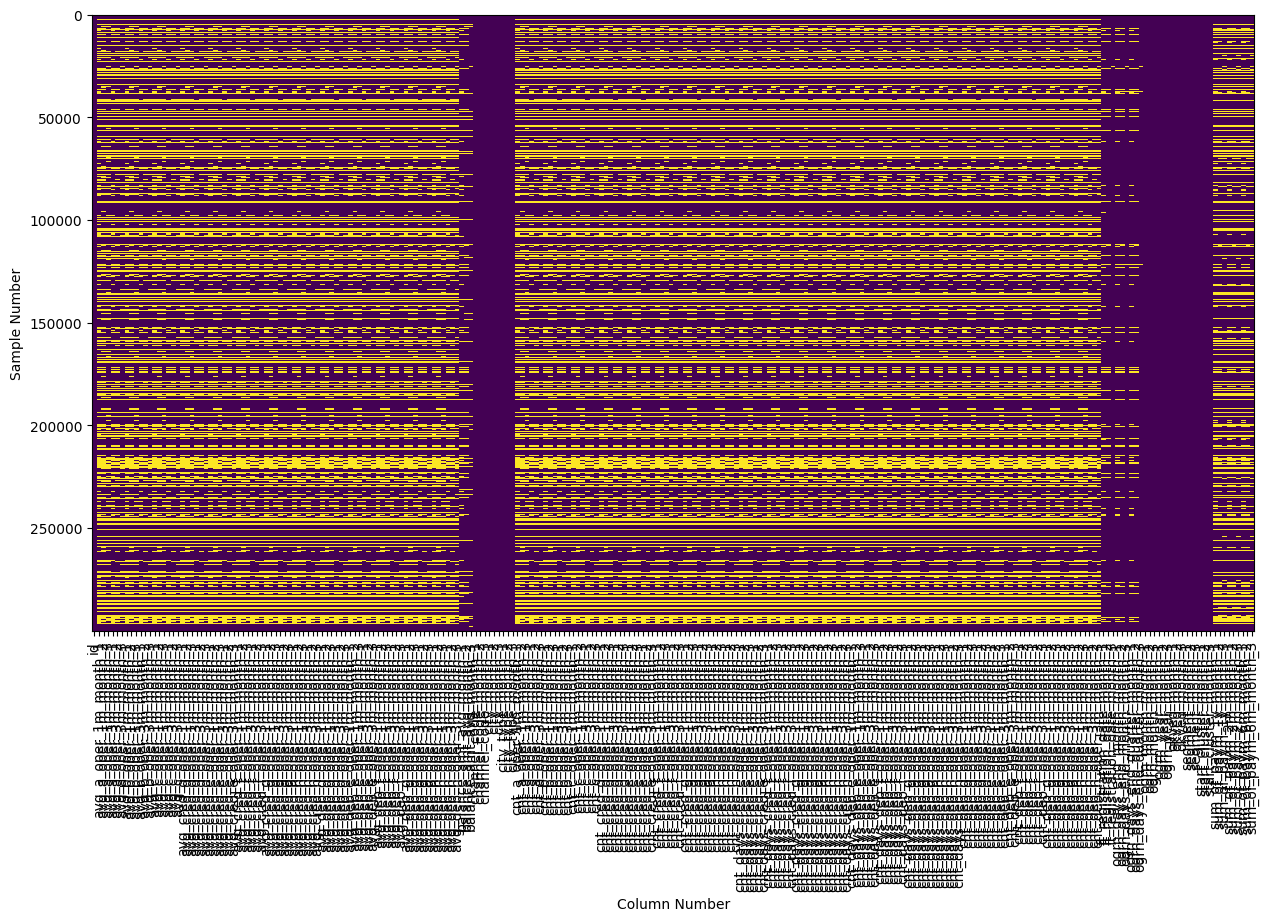

In [83]:
plt_null_df(df.isna())

## Анализ

In [8]:
train_df = df[df['id']< 200000]
test_df = df[df['id'] >= 200000]

Размерность

In [9]:
df.shape

(300000, 250)

In [10]:
train_df.shape, test_df.shape

((200000, 250), (100000, 250))

In [13]:
test_df[['id']]

,id
200000,200000
200001,200001
200002,200002
200003,200003
200004,200004
...,...
299995,299995
299996,299996
299997,299997
299998,299998


Количество строк без пропусков

In [14]:
train_df.dropna().shape

(114664, 250)

In [15]:
test_df.dropna().shape

(53150, 250)

## Предобработка

In [85]:
list(df.columns)

['id',
 'avg_a_oper_1m_month_1',
 'avg_a_oper_1m_month_2',
 'avg_a_oper_1m_month_3',
 'avg_a_oper_3m_month_1',
 'avg_a_oper_3m_month_2',
 'avg_a_oper_3m_month_3',
 'avg_b_oper_1m_month_1',
 'avg_b_oper_1m_month_2',
 'avg_b_oper_1m_month_3',
 'avg_b_oper_3m_month_1',
 'avg_b_oper_3m_month_2',
 'avg_b_oper_3m_month_3',
 'avg_c_oper_1m_month_1',
 'avg_c_oper_1m_month_2',
 'avg_c_oper_1m_month_3',
 'avg_c_oper_3m_month_1',
 'avg_c_oper_3m_month_2',
 'avg_c_oper_3m_month_3',
 'avg_cred_d_oper_1m_month_1',
 'avg_cred_d_oper_1m_month_2',
 'avg_cred_d_oper_1m_month_3',
 'avg_cred_d_oper_3m_month_1',
 'avg_cred_d_oper_3m_month_2',
 'avg_cred_d_oper_3m_month_3',
 'avg_cred_e_oper_1m_month_1',
 'avg_cred_e_oper_1m_month_2',
 'avg_cred_e_oper_1m_month_3',
 'avg_cred_e_oper_3m_month_1',
 'avg_cred_e_oper_3m_month_2',
 'avg_cred_e_oper_3m_month_3',
 'avg_cred_f_oper_1m_month_1',
 'avg_cred_f_oper_1m_month_2',
 'avg_cred_f_oper_1m_month_3',
 'avg_cred_f_oper_3m_month_1',
 'avg_cred_f_oper_3m_month_2'

In [86]:
df

,id,avg_a_oper_1m_month_1,avg_a_oper_1m_month_2,avg_a_oper_1m_month_3,avg_a_oper_3m_month_1,avg_a_oper_3m_month_2,avg_a_oper_3m_month_3,avg_b_oper_1m_month_1,avg_b_oper_1m_month_2,avg_b_oper_1m_month_3,avg_b_oper_3m_month_1,avg_b_oper_3m_month_2,avg_b_oper_3m_month_3,avg_c_oper_1m_month_1,avg_c_oper_1m_month_2,avg_c_oper_1m_month_3,avg_c_oper_3m_month_1,avg_c_oper_3m_month_2,avg_c_oper_3m_month_3,avg_cred_d_oper_1m_month_1,avg_cred_d_oper_1m_month_2,avg_cred_d_oper_1m_month_3,avg_cred_d_oper_3m_month_1,avg_cred_d_oper_3m_month_2,avg_cred_d_oper_3m_month_3,avg_cred_e_oper_1m_month_1,avg_cred_e_oper_1m_month_2,avg_cred_e_oper_1m_month_3,avg_cred_e_oper_3m_month_1,avg_cred_e_oper_3m_month_2,avg_cred_e_oper_3m_month_3,avg_cred_f_oper_1m_month_1,avg_cred_f_oper_1m_month_2,avg_cred_f_oper_1m_month_3,avg_cred_f_oper_3m_month_1,avg_cred_f_oper_3m_month_2,avg_cred_f_oper_3m_month_3,avg_cred_g_oper_1m_month_1,avg_cred_g_oper_1m_month_2,avg_cred_g_oper_1m_month_3,avg_cred_g_oper_3m_month_1,avg_cred_g_oper_3m_month_2,avg_cred_g_oper_3m_month_3,avg_cred_h_oper_1m_month_1,avg_cred_h_oper_1m_month_2,avg_cred_h_oper_1m_month_3,...,cnt_deb_f_oper_3m_month_3,cnt_deb_g_oper_1m_month_1,cnt_deb_g_oper_1m_month_2,cnt_deb_g_oper_1m_month_3,cnt_deb_g_oper_3m_month_1,cnt_deb_g_oper_3m_month_2,cnt_deb_g_oper_3m_month_3,cnt_deb_h_oper_1m_month_1,cnt_deb_h_oper_1m_month_2,cnt_deb_h_oper_1m_month_3,cnt_deb_h_oper_3m_month_1,cnt_deb_h_oper_3m_month_2,cnt_deb_h_oper_3m_month_3,ft_registration_date_month_1,ft_registration_date_month_2,ft_registration_date_month_3,ogrn_days_end_month_month_1,ogrn_days_end_month_month_2,ogrn_days_end_month_month_3,ogrn_days_end_quarter_month_1,ogrn_days_end_quarter_month_2,ogrn_days_end_quarter_month_3,ogrn_month_month_1,ogrn_month_month_2,ogrn_month_month_3,ogrn_year_month_1,ogrn_year_month_2,ogrn_year_month_3,okved_month_1,okved_month_2,okved_month_3,segment_month_1,segment_month_2,segment_month_3,start_cluster_month_1,start_cluster_month_2,start_cluster_month_3,sum_of_paym_1y_month_1,sum_of_paym_1y_month_2,sum_of_paym_1y_month_3,sum_of_paym_2m_month_1,sum_of_paym_2m_month_2,sum_of_paym_2m_month_3,sum_of_paym_6m_month_1,sum_of_paym_6m_month_2,sum_of_paym_6m_month_3
0,0,-0.4528,-0.4528,-0.4528,-0.9934,-0.9934,-0.9934,-0.0693,-0.0693,-0.0693,-0.0579,-0.0579,-0.0579,-0.1877,-0.1877,-0.1877,-0.1246,-0.1246,-0.1246,-0.2868,-0.2868,-0.2868,-0.2751,-0.2751,-0.2751,0.5789,0.1088,0.1704,0.5045,0.4758,0.3247,-0.1166,-0.1166,-0.1166,-0.1032,-0.1032,-0.1032,0.4415,-0.0957,-0.1334,0.1964,0.1318,0.0355,1.8045,0.6478,0.8779,...,0.2861,0.5139,0.5139,0.5139,0.4581,0.4581,0.4581,0.6541,0.6528,0.6534,0.5536,0.5519,0.5510,2.4522,2.4699,2.4859,-0.4886,-0.4886,-0.4886,-0.1351,-0.1351,-0.1351,ogrn_month_0,ogrn_month_0,ogrn_month_0,ogrn_year_1,ogrn_year_1,ogrn_year_1,okved_30,okved_30,okved_30,segment_1,segment_1,segment_1,"{α, γ}","{α, γ}","{α, γ}",0.5115,0.4864,0.4805,0.9423,0.6457,0.4036,0.5360,0.5364,0.6132
1,1,-0.4528,-0.4528,-0.4528,-0.9934,-0.9934,-0.9934,-0.0693,-0.0693,-0.0693,-0.0579,-0.0579,-0.0579,-0.1877,-0.1877,-0.1877,-0.1246,-0.1246,-0.1246,-0.2868,-0.2868,-0.1764,-0.2751,-0.2751,-0.2387,0.1295,-0.0411,-0.0101,0.2257,0.0689,0.0312,-0.1166,-0.1166,-0.1166,-0.1032,-0.1032,-0.1032,-0.0824,-0.1219,-0.0719,-0.0260,-0.0253,-0.0205,-0.2904,-0.2176,-0.1917,...,0.2861,0.5152,0.5165,0.5152,0.4589,0.4598,0.4598,0.6611,0.6580,0.6617,0.5671,0.5599,0.5608,0.1740,0.1918,0.2078,0.3243,0.3243,0.3243,1.2587,1.2587,1.2587,ogrn_month_5,ogrn_month_5,ogrn_month_5,ogrn_year_15,ogrn_year_15,ogrn_year_15,okved_5,okved_5,okved_5,segment_1,segment_1,segment_1,{other},{other},{other},0.0520,0.0336,0.0395,0.0141,-0.0576,-0.0921,0.0438,0.0350,0.0252
2,2,-0.4528,-0.4528,-0.4528,-0.9934,-0.9934,-0.9934,-0.0693,-0.0693,-0.0693,-0.0579,-0.0579,-0.0579,-0.1877,-0.1877,-0.1877,-0.1246,-0.1246,-0.1246,0.4713,0.3273,0.8310,0.4467,0.4975,0.5481,-0.1559,-0.1575,-0.1516,-0.1716,-0.1710,-0.1703,-0.1166,-0.1166,-0.1166,-0.1032,-0.1032,-0.1032,-0.1334,-0.1334,-0.1334,-0.0303,

In [87]:
pivot_df = df_org.pivot_table(index='id', columns='date', aggfunc='first')

# Преобразуем мультииндексные столбцы в одноуровневые
pivot_df.columns = [f'{col[0]}_{col[1]}' for col in pivot_df.columns]

# Объединяем строки для каждого клиента в одну
pivot_df.reset_index(inplace=True)
pivot_df = pivot_df.drop(columns = ['end_cluster_month_1', 'end_cluster_month_2'] , axis = 0)

In [88]:
df['end_cluster_month_3'] = pivot_df['end_cluster_month_3']

In [89]:
df['end_cluster_month_3'] = df['end_cluster_month_3'].fillna('missing')

In [90]:
df['end_cluster_month_3']

0         {other}
1         {other}
2             {α}
3          {α, γ}
4             {α}
           ...   
299995    missing
299996    missing
299997    missing
299998    missing
299999    missing
Name: end_cluster_month_3, Length: 300000, dtype: object

In [ ]:
# fill_values = {}

# # Заполнение числовых столбцов нулями
# for column in pivot_df.select_dtypes(include='number').columns:
#     fill_values[column] = 0

# # Заполнение строковых столбцов строкой "0"
# for column in pivot_df.select_dtypes(include='object').columns:
#     fill_values[column] = "0"

# # Применение заполнения к DataFrame
# pivot_df = pivot_df.fillna(value=fill_values)

In [ ]:
# columns_to_drop = [
#     'city_type_month_1', 'ogrn_year_month_2', 'sum_a_oper_1m_month_1', 'sum_a_oper_1m_month_2',
#     'sum_a_oper_1m_month_3', 'sum_a_oper_3m_month_1', 'sum_a_oper_3m_month_2', 'sum_a_oper_3m_month_3',
#     'sum_b_oper_1m_month_1', 'sum_b_oper_1m_month_2', 'sum_b_oper_1m_month_3', 'sum_b_oper_3m_month_1',
#     'sum_b_oper_3m_month_2', 'sum_b_oper_3m_month_3', 'sum_c_oper_1m_month_1', 'sum_c_oper_1m_month_2',
#     'sum_c_oper_1m_month_3', 'sum_c_oper_3m_month_1', 'sum_c_oper_3m_month_2', 'sum_c_oper_3m_month_3',
#     'sum_cred_d_oper_1m_month_1', 'sum_cred_d_oper_1m_month_2', 'sum_cred_d_oper_1m_month_3',
#     'sum_cred_d_oper_3m_month_1', 'sum_cred_d_oper_3m_month_2', 'sum_cred_d_oper_3m_month_3',
#     'sum_cred_f_oper_1m_month_1', 'sum_cred_f_oper_1m_month_2', 'sum_cred_f_oper_1m_month_3',
#     'sum_cred_f_oper_3m_month_1', 'sum_cred_f_oper_3m_month_2', 'sum_cred_f_oper_3m_month_3',
#     'sum_cred_g_oper_1m_month_1', 'sum_cred_g_oper_1m_month_2', 'sum_cred_g_oper_1m_month_3'
# ]

# pivot_df.drop(columns=columns_to_drop, inplace=True, axis = 1)

In [26]:
train_df = df[df['id']< 200000]
test_df = df[df['id'] >= 200000]

In [27]:
test_df

,id,avg_a_oper_1m_month_1,avg_a_oper_1m_month_2,avg_a_oper_1m_month_3,avg_a_oper_3m_month_1,avg_a_oper_3m_month_2,avg_a_oper_3m_month_3,avg_b_oper_1m_month_1,avg_b_oper_1m_month_2,avg_b_oper_1m_month_3,avg_b_oper_3m_month_1,avg_b_oper_3m_month_2,avg_b_oper_3m_month_3,avg_c_oper_1m_month_1,avg_c_oper_1m_month_2,avg_c_oper_1m_month_3,avg_c_oper_3m_month_1,avg_c_oper_3m_month_2,avg_c_oper_3m_month_3,avg_cred_d_oper_1m_month_1,avg_cred_d_oper_1m_month_2,avg_cred_d_oper_1m_month_3,avg_cred_d_oper_3m_month_1,avg_cred_d_oper_3m_month_2,avg_cred_d_oper_3m_month_3,avg_cred_e_oper_1m_month_1,avg_cred_e_oper_1m_month_2,avg_cred_e_oper_1m_month_3,avg_cred_e_oper_3m_month_1,avg_cred_e_oper_3m_month_2,avg_cred_e_oper_3m_month_3,avg_cred_f_oper_1m_month_1,avg_cred_f_oper_1m_month_2,avg_cred_f_oper_1m_month_3,avg_cred_f_oper_3m_month_1,avg_cred_f_oper_3m_month_2,avg_cred_f_oper_3m_month_3,avg_cred_g_oper_1m_month_1,avg_cred_g_oper_1m_month_2,avg_cred_g_oper_1m_month_3,avg_cred_g_oper_3m_month_1,avg_cred_g_oper_3m_month_2,avg_cred_g_oper_3m_month_3,avg_cred_h_oper_1m_month_1,avg_cred_h_oper_1m_month_2,avg_cred_h_oper_1m_month_3,...,cnt_deb_g_oper_1m_month_1,cnt_deb_g_oper_1m_month_2,cnt_deb_g_oper_1m_month_3,cnt_deb_g_oper_3m_month_1,cnt_deb_g_oper_3m_month_2,cnt_deb_g_oper_3m_month_3,cnt_deb_h_oper_1m_month_1,cnt_deb_h_oper_1m_month_2,cnt_deb_h_oper_1m_month_3,cnt_deb_h_oper_3m_month_1,cnt_deb_h_oper_3m_month_2,cnt_deb_h_oper_3m_month_3,ft_registration_date_month_1,ft_registration_date_month_2,ft_registration_date_month_3,ogrn_days_end_month_month_1,ogrn_days_end_month_month_2,ogrn_days_end_month_month_3,ogrn_days_end_quarter_month_1,ogrn_days_end_quarter_month_2,ogrn_days_end_quarter_month_3,ogrn_month_month_1,ogrn_month_month_2,ogrn_month_month_3,ogrn_year_month_1,ogrn_year_month_2,ogrn_year_month_3,okved_month_1,okved_month_2,okved_month_3,segment_month_1,segment_month_2,segment_month_3,start_cluster_month_1,start_cluster_month_2,start_cluster_month_3,sum_of_paym_1y_month_1,sum_of_paym_1y_month_2,sum_of_paym_1y_month_3,sum_of_paym_2m_month_1,sum_of_paym_2m_month_2,sum_of_paym_2m_month_3,sum_of_paym_6m_month_1,sum_of_paym_6m_month_2,sum_of_paym_6m_month_3,end_cluster_month_3
200000,200000,1.2619,-0.1648,6.2595,4.4611,4.6360,5.4649,-0.0693,-0.0693,-0.0693,-0.0579,-0.0579,-0.0579,2.0327,8.9619,7.5097,1.7235,3.1367,4.3126,-0.2868,0.3991,-0.2868,-0.1783,-0.0261,-0.0477,0.3049,0.1510,0.1041,0.1660,0.2191,0.2144,-0.1166,-0.1166,-0.1166,-0.1032,-0.1032,-0.1032,0.3463,-0.1334,-0.1334,0.0116,0.0072,0.0072,0.6833,0.5932,0.3619,...,0.5152,0.5146,0.5152,0.4607,0.4596,0.4592,0.6525,0.6522,0.6519,0.5489,0.5495,0.5495,-0.6538,-0.6366,-0.6189,-1.5337,-1.5337,-1.5337,-1.6837,-1.6837,-1.6837,ogrn_month_8,ogrn_month_8,ogrn_month_8,ogrn_year_11,ogrn_year_11,ogrn_year_11,okved_0,okved_0,okved_0,segment_3,segment_3,segment_3,{α},{α},{α},0.6766,0.6884,0.6719,0.4168,0.4332,0.2240,0.3324,0.2843,0.2854,NaN
200001,200001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.6630,-0.6458,-0.6281,0.0921,0.0921,0.0921,1.2200,1.2200,1.2200,ogrn_month_10,ogrn_month_10,ogrn_month_10,ogrn_year_11,ogrn_year_11,ogrn_year_11,okved_6,okved_6,okved_6,segment_3,segment_3,segment_3,{α},{α},{α},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200002,200002,9.3303,43.0412,24.7229,16.9913,45.0169,49.5095,-0.0693,-0.0693,-0.0693,-0.0579,-0.0579,-0.0579,2.8631,6.9606,3.0827,0.6740,2.2542,3.0010,-0.2868,-0.2868,-0.2868,-0.2751,-0.2751,-0.2751,1.3671,3.1970,1.3666,0.7800,1.9584,2.1341,-0.1166,-0.1166,-0.1166,-0.1032,-0.1032,-0.1032,3.0402,0.1662,0.1320,0.5372,0.5262,0.1301,2.3478,12.1308,4.6399,...,0.5172,0.5217,0.5223,0.4614,0.4630,0.4647,0.6587,0.6737,0.6587,0.5549,0.5639,0.5651,-0.7562,-0.7391,-0.7213,-1.0692,-1.0692,-1.0692,-1.5289,-1.5289,-1.5289,ogrn_month_6,ogrn_month_6,ogrn_month_6,ogrn_year_11,ogrn_year_11,ogr

Обозначение категориальных признаков

In [91]:
cat_names = [
    "channel_code", "city", "city_type", "ogrn_month", "ogrn_year",
    "okved", "segment", "start_cluster"
]



cat_names = list(pivot_df.select_dtypes(exclude= 'number').columns)


In [ ]:
cat_names.remove("end_cluster_month_3")

In [ ]:
cat_names

['channel_code_month_1',
 'channel_code_month_2',
 'channel_code_month_3',
 'city_month_1',
 'city_month_2',
 'city_month_3',
 'city_type_month_2',
 'city_type_month_3',
 'ogrn_month_month_1',
 'ogrn_month_month_2',
 'ogrn_month_month_3',
 'ogrn_year_month_1',
 'ogrn_year_month_3',
 'okved_month_1',
 'okved_month_2',
 'okved_month_3',
 'segment_month_1',
 'segment_month_2',
 'segment_month_3',
 'start_cluster_month_1',
 'start_cluster_month_2',
 'start_cluster_month_3']

In [ ]:

label_encoders = {}

for col in cat_names:
    print(col)
    label_encoders[col] = LabelEncoder().fit(pivot_df[col])

    train_df[col] = label_encoders[col].transform(train_df[col])
    test_df[col] = label_encoders[col].transform(test_df[col])

channel_code_month_1

channel_code_month_2

channel_code_month_3

city_month_1

city_month_2

city_month_3

city_type_month_2

city_type_month_3

ogrn_month_month_1

ogrn_month_month_2

ogrn_month_month_3

ogrn_year_month_1

ogrn_year_month_3

okved_month_1

okved_month_2

okved_month_3

segment_month_1

segment_month_2

segment_month_3

start_cluster_month_1

start_cluster_month_2

start_cluster_month_3


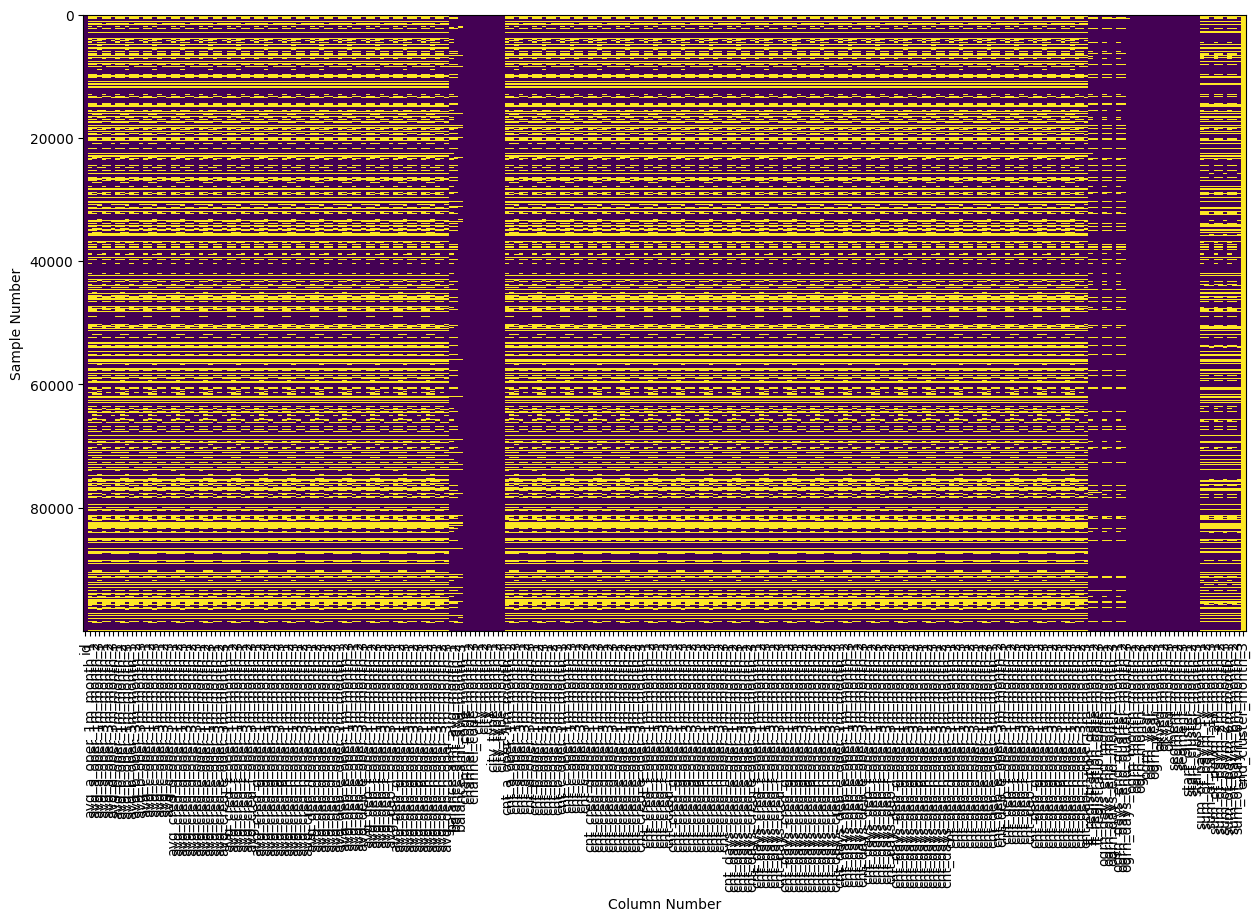

In [92]:
plt_null_df(test_df.isna())

### Создаем каждого клиента со всеми его признаками

### Создаем выборки для валидации и обучения

Деление на обучающую и тестовую, исправляем дизбаланс классов, если не требуется, пропустить эти блоки до следующего текста

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>

Index: 97440 entries, 0 to 97439

Columns: 118 entries, id to sum_deb_h_oper_3m_month_3

dtypes: float64(90), int64(25), object(3)

memory usage: 88.5+ MB


In [165]:
X = train_df.drop(["id"], axis=1) # оставляю end_cluster чтобы получить пропорцию классов, а потом ниже удалю в коде
y = train_df["end_cluster_month_3"]

x_train, x_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42)

In [94]:
# X = train_df.drop(["id"], axis=1) # оставляю end_cluster чтобы получить пропорцию классов, а потом ниже удалю в коде
# y = train_df["end_cluster_month_3"]



In [166]:
x_train['end_cluster_month_3'].value_counts().median()

1432.0

In [137]:
# Определение желаемого количества экземпляров каждого класса
desired_class_count = 1000  # Укажите ваше желаемое количество экземпляров

# Обработка дисбаланса классов
balanced_data = pd.DataFrame()
for cluster in x_train['end_cluster_month_3'].unique():
    cluster_data = x_train[x_train['end_cluster_month_3'] == cluster]
    if len(cluster_data) < desired_class_count:
        resampled_data = resample(
            cluster_data, replace=True, n_samples=desired_class_count, random_state=42)
    else:
        resampled_data = cluster_data.sample(
            n=desired_class_count, replace=False, random_state=42)
    balanced_data = pd.concat([balanced_data, resampled_data])

In [138]:
balanced_data['end_cluster_month_3'].value_counts()

end_cluster_month_3
{α}          1000
{}           1000
{α, η}       1000
{α, β}       1000
{other}      1000
{α, γ}       1000
{α, θ}       1000
{α, δ}       1000
{α, μ}       1000
{α, ε}       1000
{α, ε, θ}    1000
{α, ε, η}    1000
{α, ψ}       1000
{α, ε, ψ}    1000
{λ}          1000
{α, λ}       1000
{α, π}       1000
Name: count, dtype: int64

In [139]:
x_train = balanced_data

In [42]:
# Calculate current class proportions
class_proportions = x_train['end_cluster_month_3'].value_counts(normalize=True)

# Identify underrepresented classes
underrepresented_classes = class_proportions[class_proportions < 0.08].index

# Create an empty list to store additional rows
additional_rows = []

# Calculate the number of additional rows needed for each underrepresented class
for class_label in underrepresented_classes:
    current_proportion = class_proportions[class_label]
    desired_proportion = 0.08
    current_count = (x_train['end_cluster_month_3'] == class_label).sum()
    desired_count = int(desired_proportion * len(train_df))
    additional_count = desired_count - current_count

    if additional_count > 0:
        additional_samples = x_train[x_train['end_cluster_month_3'] == class_label].sample(n=additional_count, replace=True)
        additional_rows.append(additional_samples)

# Concatenate additional rows with the original dataframe
if additional_rows:
    x_train = pd.concat([x_train] + additional_rows, ignore_index=True)

# Verify the class proportions after balancing
print(x_train['end_cluster_month_3'].value_counts())


end_cluster_month_3
{α}          84479
{}           33282
{α, η}       16000
{α, β}       16000
{other}      16000
{α, γ}       16000
{α, θ}       16000
{α, δ}       16000
{α, μ}       16000
{α, ε}       16000
{α, ε, θ}    16000
{α, ε, η}    16000
{α, ψ}       16000
{α, ε, ψ}    16000
{λ}          16000
{α, λ}       16000
{α, π}       16000
Name: count, dtype: int64


In [167]:
y_train = x_train['end_cluster_month_3']
x_train = x_train.drop(['end_cluster_month_3'], axis=1)
x_val = x_val.drop(['end_cluster_month_3'], axis=1)

In [168]:
x_train['end_cluster_month_3']

KeyError: 'end_cluster_month_3'

In [169]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((160000, 249), (160000,), (40000, 249), (40000,))

In [170]:
y_train.value_counts()

end_cluster_month_3
{α}          84479
{}           33282
{other}      13280
{α, η}       10016
{α, γ}        9022
{α, β}        2934
{α, θ}        1785
{α, ε}        1476
{α, δ}        1432
{α, ψ}         664
{α, μ}         587
{α, ε, η}      400
{α, ε, θ}      297
{α, λ}         218
{α, ε, ψ}       79
{λ}             45
{α, π}           4
Name: count, dtype: int64

Деление на тестовую и обучающую выборку без дизбаланса

In [143]:
# X = train_df.drop(["id", "date", "end_cluster"], axis=1)
# y = train_df["end_cluster"]

# x_train, x_val, y_train, y_val = train_test_split(X, y,
#                                                   test_size=0.2,
#                                                   random_state=42)

## Обучение модели

Кросс-валидация для CatBoost (не нажимать если не разбираешься). Если не разбираешься, идти к следующему блоку текста

In [ ]:
from catboost import cv

params = {
    'loss_function': 'MultiClass',
    'iterations': 512,
    'random_seed': 43,
    'learning_rate': 0.1,
    'depth': 12,
    'task_type': 'GPU',
    'devices':'0'
}

cv_data = cv(
    params=params,
    pool=pool1,
    fold_count=5, # Разбивка выборки на 5 кусочков
    shuffle=True, # Перемешаем наши данные
    partition_random_seed=0,
    plot=True, # Никуда без визуализатора
    stratified=True,
    verbose=30
)

In [ ]:
cv_data

In [ ]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])
print("Best validation Logloss score, stratified: {:.4f}+/-{:.3f} on step {}".format(
best_value, cv_data['test-Logloss-std'][best_iter], best_iter))

## Начало обучения

### CatBoostClassifier

model #13, classes balanced

In [171]:
model = CatBoostClassifier(iterations=1024,
                           depth=8,
                           learning_rate=0.075,
                           random_seed=47,
                           loss_function='MultiClass',
                           task_type="GPU",
                           devices='0',
                           early_stopping_rounds=20
                          )


In [172]:
def train_catboost(model, x_train, y_train, x_val, y_val, cat_names):

    model.fit(
    x_train, y_train,
    cat_features=np.array(cat_names),
    eval_set=(x_val, y_val),
    verbose=15 # через сколько итераций выводить стату
    )
    model.save_model('catboost_model_no_end_claster.json') # сохранение модели
    feature_importance = model.get_feature_importance(prettified=True) # датасет с важностью признаков

    return feature_importance

In [173]:
y_val

119737        {α}
72272     {other}
158154        {α}
65426     {other}
30074         {α}
           ...   
4174           {}
91537          {}
156449        {α}
184376     {α, η}
6584       {α, γ}
Name: end_cluster_month_3, Length: 40000, dtype: object

In [174]:
cat_names = x_train.select_dtypes(exclude = 'number').columns

In [175]:
feature_importance = train_catboost(model, x_train, y_train, x_val, y_val, cat_names)

0:	learn: 2.2576734	test: 2.2093584	best: 2.2093584 (0)	total: 180ms	remaining: 3m 4s
15:	learn: 1.1290467	test: 1.0340480	best: 1.0340480 (15)	total: 1.85s	remaining: 1m 56s
30:	learn: 0.9550796	test: 0.8644494	best: 0.8644494 (30)	total: 3.67s	remaining: 1m 57s
45:	learn: 0.9001813	test: 0.8158213	best: 0.8158213 (45)	total: 5.52s	remaining: 1m 57s
60:	learn: 0.8771751	test: 0.7986682	best: 0.7986682 (60)	total: 7.25s	remaining: 1m 54s
75:	learn: 0.8616407	test: 0.7886166	best: 0.7886166 (75)	total: 9.13s	remaining: 1m 53s
90:	learn: 0.8507243	test: 0.7833146	best: 0.7833146 (90)	total: 11s	remaining: 1m 52s
105:	learn: 0.8422630	test: 0.7796691	best: 0.7796691 (105)	total: 12.8s	remaining: 1m 50s
120:	learn: 0.8351621	test: 0.7770717	best: 0.7770717 (120)	total: 14.6s	remaining: 1m 48s
135:	learn: 0.8283265	test: 0.7745505	best: 0.7745505 (135)	total: 16.4s	remaining: 1m 46s
150:	learn: 0.8229146	test: 0.7726578	best: 0.7726578 (150)	total: 18.1s	remaining: 1m 44s
165:	learn: 0.8177

In [57]:
feature_importance = train_catboost(model, x_train, y_train, x_val, y_val, cat_names)

0:	learn: 2.5250742	test: 2.4779668	best: 2.4779668 (0)	total: 355ms	remaining: 11m 59s
15:	learn: 1.6776444	test: 1.3998063	best: 1.3998063 (15)	total: 2.63s	remaining: 5m 30s
30:	learn: 1.4519761	test: 1.2150313	best: 1.2150313 (30)	total: 5.03s	remaining: 5m 24s
45:	learn: 1.3284413	test: 1.1413579	best: 1.1413579 (45)	total: 7.27s	remaining: 5m 13s
60:	learn: 1.2242789	test: 1.1050612	best: 1.1050612 (60)	total: 9.65s	remaining: 5m 11s
75:	learn: 1.1563288	test: 1.0837194	best: 1.0837194 (75)	total: 11.9s	remaining: 5m 5s
90:	learn: 1.0954909	test: 1.0635689	best: 1.0635689 (90)	total: 14.3s	remaining: 5m 4s
105:	learn: 1.0485906	test: 1.0473963	best: 1.0473963 (105)	total: 16.6s	remaining: 5m 1s
120:	learn: 1.0121175	test: 1.0358008	best: 1.0358008 (120)	total: 18.9s	remaining: 4m 57s
135:	learn: 0.9712221	test: 1.0236580	best: 1.0236580 (135)	total: 21.2s	remaining: 4m 55s
150:	learn: 0.9350810	test: 1.0120471	best: 1.0120471 (150)	total: 23.5s	remaining: 4m 52s
165:	learn: 0.905

In [176]:
feature_importance

,Feature Id,Importances
0,start_cluster_month_2,8.8797
1,balance_amt_avg_month_3,4.3938
2,city_month_1,3.9637
3,okved_month_3,3.8348
4,start_cluster_month_1,3.1853
...,...,...
244,city_month_2,0.0000
245,city_type_month_2,0.0000
246,city_type_month_3,0.0000
247,cnt_a_oper_1m_month_3,0.0000


In [77]:
feature_importance.head(30)

,Feature Id,Importances
0,start_cluster_month_2,6.7901
1,start_cluster_month_1,3.9013
2,balance_amt_avg_month_3,3.8520
3,city_month_2,3.7200
4,okved_month_1,3.2414
5,start_cluster_month_3,3.1309
6,okved_month_3,2.8782
7,balance_amt_avg_month_2,2.6931
8,ft_registration_date_month_3,2.4787
9,city_month_3,2.4750


Модель LGBM, блоки кода не нажимать чтобы не сбросилась model CatBoost. Я еще не тестил эту модель, переходи к метрикам

### LGBM

В качестве базовой модели возьмем LGBM обучим на всех признаках

In [ ]:
model = LGBMClassifier(verbosity=-1, random_state=42, n_jobs=-1)
model.fit(x_train, y_train)

LGBMClassifier(n_jobs=-1, random_state=42, verbosity=-1)

### Ансамбль 2

In [ ]:
%%time
base_models = [
    ('catboost', CatBoostClassifier(iterations=1024,
                                     depth=4,
                                     learning_rate=0.075,
                                     random_seed=43,
                                     loss_function='MultiClass',
                                     task_type="GPU",
                                     devices='0',
                                     early_stopping_rounds=20,
                                     verbose=500)),
    ('lgbm', LGBMClassifier(n_estimators=100, max_depth=3, verbosity=-1, random_state=42, n_jobs=-1, tree_method= 'gpu_hist')),
    ('extra_trees', ExtraTreesClassifier(n_estimators=50, max_depth=3, random_state=42),
    ('xgboost', XGBClassifier(n_estimators=100, max_depth=3, verbosity=0, random_state=42, n_jobs=-1, tree_method= 'gpu_hist')))
]

meta_model = RandomForestClassifier(n_estimators=50, random_state=42, max_depth=5)

model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

model.fit(x_train, y_train)

0:	learn: 2.6243071	total: 186ms	remaining: 3m 10s

500:	learn: 0.9703673	total: 12s	remaining: 12.5s

1000:	learn: 0.7911291	total: 20.4s	remaining: 470ms

1023:	learn: 0.7856069	total: 20.8s	remaining: 0us


ValueError: Input X contains NaN.
ExtraTreesClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

### Метрики

Зададим функцию для взвешенной метрики roc auc

In [177]:
def weighted_roc_auc(y_true, y_pred, labels, weights_dict):
    unnorm_weights = np.array([weights_dict[label] for label in labels])
    weights = unnorm_weights / unnorm_weights.sum()
    classes_roc_auc = roc_auc_score(y_true, y_pred, labels=labels,
                                    multi_class="ovr", average=None)
    return sum(weights * classes_roc_auc)

In [178]:
cluster_weights = pd.read_excel("/kaggle/input/alfa-hak1/cluster_weights.xlsx").set_index("cluster")
weights_dict = cluster_weights["unnorm_weight"].to_dict()

Проверка работы модели

In [179]:
y_pred_proba = model.predict_proba(x_val)
y_pred_proba.shape

(40000, 17)

In [180]:
y_val

119737        {α}
72272     {other}
158154        {α}
65426     {other}
30074         {α}
           ...   
4174           {}
91537          {}
156449        {α}
184376     {α, η}
6584       {α, γ}
Name: end_cluster_month_3, Length: 40000, dtype: object

In [181]:
y_pred_proba[0]

array([4.56753433e-02, 2.62172021e-03, 7.19398474e-02, 8.79682402e-02,
       1.58051762e-02, 1.01749114e-04, 2.87427768e-04, 1.32289903e-04,
       1.96534217e-03, 3.13228069e-03, 1.77887453e-03, 2.16694554e-03,
       1.66721657e-03, 4.53659642e-05, 1.24002928e-03, 7.63412430e-01,
       5.97207319e-05])

In [182]:
weighted_roc_auc(y_val, y_pred_proba, model.classes_, weights_dict)

0.9154721109949079

## Прогноз на тестовой выборке

In [67]:
test_df

,id,avg_a_oper_1m_month_1,avg_a_oper_1m_month_2,avg_a_oper_1m_month_3,avg_a_oper_3m_month_1,avg_a_oper_3m_month_2,avg_a_oper_3m_month_3,avg_b_oper_1m_month_1,avg_b_oper_1m_month_2,avg_b_oper_1m_month_3,avg_b_oper_3m_month_1,avg_b_oper_3m_month_2,avg_b_oper_3m_month_3,avg_c_oper_1m_month_1,avg_c_oper_1m_month_2,avg_c_oper_1m_month_3,avg_c_oper_3m_month_1,avg_c_oper_3m_month_2,avg_c_oper_3m_month_3,avg_cred_d_oper_1m_month_1,avg_cred_d_oper_1m_month_2,avg_cred_d_oper_1m_month_3,avg_cred_d_oper_3m_month_1,avg_cred_d_oper_3m_month_2,avg_cred_d_oper_3m_month_3,avg_cred_e_oper_1m_month_1,avg_cred_e_oper_1m_month_2,avg_cred_e_oper_1m_month_3,avg_cred_e_oper_3m_month_1,avg_cred_e_oper_3m_month_2,avg_cred_e_oper_3m_month_3,avg_cred_f_oper_1m_month_1,avg_cred_f_oper_1m_month_2,avg_cred_f_oper_1m_month_3,avg_cred_f_oper_3m_month_1,avg_cred_f_oper_3m_month_2,avg_cred_f_oper_3m_month_3,avg_cred_g_oper_1m_month_1,avg_cred_g_oper_1m_month_2,avg_cred_g_oper_1m_month_3,avg_cred_g_oper_3m_month_1,avg_cred_g_oper_3m_month_2,avg_cred_g_oper_3m_month_3,avg_cred_h_oper_1m_month_1,avg_cred_h_oper_1m_month_2,avg_cred_h_oper_1m_month_3,...,cnt_deb_g_oper_1m_month_1,cnt_deb_g_oper_1m_month_2,cnt_deb_g_oper_1m_month_3,cnt_deb_g_oper_3m_month_1,cnt_deb_g_oper_3m_month_2,cnt_deb_g_oper_3m_month_3,cnt_deb_h_oper_1m_month_1,cnt_deb_h_oper_1m_month_2,cnt_deb_h_oper_1m_month_3,cnt_deb_h_oper_3m_month_1,cnt_deb_h_oper_3m_month_2,cnt_deb_h_oper_3m_month_3,ft_registration_date_month_1,ft_registration_date_month_2,ft_registration_date_month_3,ogrn_days_end_month_month_1,ogrn_days_end_month_month_2,ogrn_days_end_month_month_3,ogrn_days_end_quarter_month_1,ogrn_days_end_quarter_month_2,ogrn_days_end_quarter_month_3,ogrn_month_month_1,ogrn_month_month_2,ogrn_month_month_3,ogrn_year_month_1,ogrn_year_month_2,ogrn_year_month_3,okved_month_1,okved_month_2,okved_month_3,segment_month_1,segment_month_2,segment_month_3,start_cluster_month_1,start_cluster_month_2,start_cluster_month_3,sum_of_paym_1y_month_1,sum_of_paym_1y_month_2,sum_of_paym_1y_month_3,sum_of_paym_2m_month_1,sum_of_paym_2m_month_2,sum_of_paym_2m_month_3,sum_of_paym_6m_month_1,sum_of_paym_6m_month_2,sum_of_paym_6m_month_3,end_cluster_month_3
200000,200000,1.2619,-0.1648,6.2595,4.4611,4.6360,5.4649,-0.0693,-0.0693,-0.0693,-0.0579,-0.0579,-0.0579,2.0327,8.9619,7.5097,1.7235,3.1367,4.3126,-0.2868,0.3991,-0.2868,-0.1783,-0.0261,-0.0477,0.3049,0.1510,0.1041,0.1660,0.2191,0.2144,-0.1166,-0.1166,-0.1166,-0.1032,-0.1032,-0.1032,0.3463,-0.1334,-0.1334,0.0116,0.0072,0.0072,0.6833,0.5932,0.3619,...,0.5152,0.5146,0.5152,0.4607,0.4596,0.4592,0.6525,0.6522,0.6519,0.5489,0.5495,0.5495,-0.6538,-0.6366,-0.6189,-1.5337,-1.5337,-1.5337,-1.6837,-1.6837,-1.6837,ogrn_month_8,ogrn_month_8,ogrn_month_8,ogrn_year_11,ogrn_year_11,ogrn_year_11,okved_0,okved_0,okved_0,segment_3,segment_3,segment_3,{α},{α},{α},0.6766,0.6884,0.6719,0.4168,0.4332,0.2240,0.3324,0.2843,0.2854,NaN
200001,200001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.6630,-0.6458,-0.6281,0.0921,0.0921,0.0921,1.2200,1.2200,1.2200,ogrn_month_10,ogrn_month_10,ogrn_month_10,ogrn_year_11,ogrn_year_11,ogrn_year_11,okved_6,okved_6,okved_6,segment_3,segment_3,segment_3,{α},{α},{α},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200002,200002,9.3303,43.0412,24.7229,16.9913,45.0169,49.5095,-0.0693,-0.0693,-0.0693,-0.0579,-0.0579,-0.0579,2.8631,6.9606,3.0827,0.6740,2.2542,3.0010,-0.2868,-0.2868,-0.2868,-0.2751,-0.2751,-0.2751,1.3671,3.1970,1.3666,0.7800,1.9584,2.1341,-0.1166,-0.1166,-0.1166,-0.1032,-0.1032,-0.1032,3.0402,0.1662,0.1320,0.5372,0.5262,0.1301,2.3478,12.1308,4.6399,...,0.5172,0.5217,0.5223,0.4614,0.4630,0.4647,0.6587,0.6737,0.6587,0.5549,0.5639,0.5651,-0.7562,-0.7391,-0.7213,-1.0692,-1.0692,-1.0692,-1.5289,-1.5289,-1.5289,ogrn_month_6,ogrn_month_6,ogrn_month_6,ogrn_year_11,ogrn_year_11,ogr

In [69]:
cat_names

Index(['channel_code_month_1', 'channel_code_month_2', 'channel_code_month_3',
       'city_month_1', 'city_month_2', 'city_month_3', 'city_type_month_1',
       'city_type_month_2', 'city_type_month_3', 'ogrn_month_month_1',
       'ogrn_month_month_2', 'ogrn_month_month_3', 'ogrn_year_month_1',
       'ogrn_year_month_2', 'ogrn_year_month_3', 'okved_month_1',
       'okved_month_2', 'okved_month_3', 'segment_month_1', 'segment_month_2',
       'segment_month_3', 'start_cluster_month_1', 'start_cluster_month_2',
       'start_cluster_month_3'],
      dtype='object')

In [184]:
test_df

,id,avg_a_oper_1m_month_1,avg_a_oper_1m_month_2,avg_a_oper_1m_month_3,avg_a_oper_3m_month_1,avg_a_oper_3m_month_2,avg_a_oper_3m_month_3,avg_b_oper_1m_month_1,avg_b_oper_1m_month_2,avg_b_oper_1m_month_3,avg_b_oper_3m_month_1,avg_b_oper_3m_month_2,avg_b_oper_3m_month_3,avg_c_oper_1m_month_1,avg_c_oper_1m_month_2,avg_c_oper_1m_month_3,avg_c_oper_3m_month_1,avg_c_oper_3m_month_2,avg_c_oper_3m_month_3,avg_cred_d_oper_1m_month_1,avg_cred_d_oper_1m_month_2,avg_cred_d_oper_1m_month_3,avg_cred_d_oper_3m_month_1,avg_cred_d_oper_3m_month_2,avg_cred_d_oper_3m_month_3,avg_cred_e_oper_1m_month_1,avg_cred_e_oper_1m_month_2,avg_cred_e_oper_1m_month_3,avg_cred_e_oper_3m_month_1,avg_cred_e_oper_3m_month_2,avg_cred_e_oper_3m_month_3,avg_cred_f_oper_1m_month_1,avg_cred_f_oper_1m_month_2,avg_cred_f_oper_1m_month_3,avg_cred_f_oper_3m_month_1,avg_cred_f_oper_3m_month_2,avg_cred_f_oper_3m_month_3,avg_cred_g_oper_1m_month_1,avg_cred_g_oper_1m_month_2,avg_cred_g_oper_1m_month_3,avg_cred_g_oper_3m_month_1,avg_cred_g_oper_3m_month_2,avg_cred_g_oper_3m_month_3,avg_cred_h_oper_1m_month_1,avg_cred_h_oper_1m_month_2,avg_cred_h_oper_1m_month_3,...,cnt_deb_g_oper_1m_month_1,cnt_deb_g_oper_1m_month_2,cnt_deb_g_oper_1m_month_3,cnt_deb_g_oper_3m_month_1,cnt_deb_g_oper_3m_month_2,cnt_deb_g_oper_3m_month_3,cnt_deb_h_oper_1m_month_1,cnt_deb_h_oper_1m_month_2,cnt_deb_h_oper_1m_month_3,cnt_deb_h_oper_3m_month_1,cnt_deb_h_oper_3m_month_2,cnt_deb_h_oper_3m_month_3,ft_registration_date_month_1,ft_registration_date_month_2,ft_registration_date_month_3,ogrn_days_end_month_month_1,ogrn_days_end_month_month_2,ogrn_days_end_month_month_3,ogrn_days_end_quarter_month_1,ogrn_days_end_quarter_month_2,ogrn_days_end_quarter_month_3,ogrn_month_month_1,ogrn_month_month_2,ogrn_month_month_3,ogrn_year_month_1,ogrn_year_month_2,ogrn_year_month_3,okved_month_1,okved_month_2,okved_month_3,segment_month_1,segment_month_2,segment_month_3,start_cluster_month_1,start_cluster_month_2,start_cluster_month_3,sum_of_paym_1y_month_1,sum_of_paym_1y_month_2,sum_of_paym_1y_month_3,sum_of_paym_2m_month_1,sum_of_paym_2m_month_2,sum_of_paym_2m_month_3,sum_of_paym_6m_month_1,sum_of_paym_6m_month_2,sum_of_paym_6m_month_3,end_cluster_month_3
200000,200000,1.2619,-0.1648,6.2595,4.4611,4.6360,5.4649,-0.0693,-0.0693,-0.0693,-0.0579,-0.0579,-0.0579,2.0327,8.9619,7.5097,1.7235,3.1367,4.3126,-0.2868,0.3991,-0.2868,-0.1783,-0.0261,-0.0477,0.3049,0.1510,0.1041,0.1660,0.2191,0.2144,-0.1166,-0.1166,-0.1166,-0.1032,-0.1032,-0.1032,0.3463,-0.1334,-0.1334,0.0116,0.0072,0.0072,0.6833,0.5932,0.3619,...,0.5152,0.5146,0.5152,0.4607,0.4596,0.4592,0.6525,0.6522,0.6519,0.5489,0.5495,0.5495,-0.6538,-0.6366,-0.6189,-1.5337,-1.5337,-1.5337,-1.6837,-1.6837,-1.6837,ogrn_month_8,ogrn_month_8,ogrn_month_8,ogrn_year_11,ogrn_year_11,ogrn_year_11,okved_0,okved_0,okved_0,segment_3,segment_3,segment_3,{α},{α},{α},0.6766,0.6884,0.6719,0.4168,0.4332,0.2240,0.3324,0.2843,0.2854,NaN
200001,200001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.6630,-0.6458,-0.6281,0.0921,0.0921,0.0921,1.2200,1.2200,1.2200,ogrn_month_10,ogrn_month_10,ogrn_month_10,ogrn_year_11,ogrn_year_11,ogrn_year_11,okved_6,okved_6,okved_6,segment_3,segment_3,segment_3,{α},{α},{α},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200002,200002,9.3303,43.0412,24.7229,16.9913,45.0169,49.5095,-0.0693,-0.0693,-0.0693,-0.0579,-0.0579,-0.0579,2.8631,6.9606,3.0827,0.6740,2.2542,3.0010,-0.2868,-0.2868,-0.2868,-0.2751,-0.2751,-0.2751,1.3671,3.1970,1.3666,0.7800,1.9584,2.1341,-0.1166,-0.1166,-0.1166,-0.1032,-0.1032,-0.1032,3.0402,0.1662,0.1320,0.5372,0.5262,0.1301,2.3478,12.1308,4.6399,...,0.5172,0.5217,0.5223,0.4614,0.4630,0.4647,0.6587,0.6737,0.6587,0.5549,0.5639,0.5651,-0.7562,-0.7391,-0.7213,-1.0692,-1.0692,-1.0692,-1.5289,-1.5289,-1.5289,ogrn_month_6,ogrn_month_6,ogrn_month_6,ogrn_year_11,ogrn_year_11,ogr

In [185]:
cat_names

Index(['channel_code_month_1', 'channel_code_month_2', 'channel_code_month_3',
       'city_month_1', 'city_month_2', 'city_month_3', 'city_type_month_1',
       'city_type_month_2', 'city_type_month_3', 'ogrn_month_month_1',
       'ogrn_month_month_2', 'ogrn_month_month_3', 'ogrn_year_month_1',
       'ogrn_year_month_2', 'ogrn_year_month_3', 'okved_month_1',
       'okved_month_2', 'okved_month_3', 'segment_month_1', 'segment_month_2',
       'segment_month_3', 'start_cluster_month_1', 'start_cluster_month_2',
       'start_cluster_month_3'],
      dtype='object')

In [186]:
sample_submission_df = pd.read_csv("/kaggle/input/alfa-hak1/sample_submission.csv") # поменять на свой
last_m_test_df = test_df
last_m_test_df = last_m_test_df.drop(["id"], axis=1)

pool2 = Pool(data=last_m_test_df, cat_features=np.array(cat_names))

test_pred_proba = model.predict_proba(pool2) # last_m_test_df
test_pred_proba_df = pd.DataFrame(test_pred_proba, columns=model.classes_)
sorted_classes = sorted(test_pred_proba_df.columns.to_list())
test_pred_proba_df = test_pred_proba_df[sorted_classes]

sample_submission_df[sorted_classes] = test_pred_proba_df
sample_submission_df.to_csv("catboost_submission_akm_month4.csv", index=False) # сохранение модели

In [ ]:
sample_submission_df = pd.read_csv("/content/drive/MyDrive/Alfa-hak/sample_submission.csv") # поменять на свой
last_m_test_df = test_df
last_m_test_df = last_m_test_df.drop("id", axis=1)

pool2 = Pool(data=last_m_test_df, cat_features=np.array(cat_names))

test_pred_proba = model.predict_proba(pool2) # last_m_test_df
test_pred_proba_df = pd.DataFrame(test_pred_proba, columns=model.classes_)
sorted_classes = sorted(test_pred_proba_df.columns.to_list())
test_pred_proba_df = test_pred_proba_df[sorted_classes]

sample_submission_df[sorted_classes] = test_pred_proba_df
sample_submission_df.to_csv("catboost_submission_akm_4.csv", index=False) # сохранение модели

In [ ]:
sample_submission_df.shape # если (100000, 18), то все правильно. Если нет - надо писать Кариму и спрашивать(

(100000, 18)

In [ ]:
sample_submission_df

,id,{other},{},"{α, β}","{α, γ}","{α, δ}","{α, ε, η}","{α, ε, θ}","{α, ε, ψ}","{α, ε}","{α, η}","{α, θ}","{α, λ}","{α, μ}","{α, π}","{α, ψ}",{α},{λ}
0,200000,0.0080,0.0023,0.0008,0.0009,0.8542,0.0002,0.0029,0.0002,0.0008,0.0012,0.0042,0.0002,0.0014,0.0001,0.0008,0.1219,0.0000
1,200001,0.0115,0.0072,0.0005,0.0011,0.7917,0.0006,0.0017,0.0005,0.0038,0.0011,0.0012,0.0003,0.0035,0.0000,0.0020,0.1727,0.0006
2,200002,0.0213,0.0001,0.0003,0.0016,0.8951,0.0004,0.0063,0.0038,0.0018,0.0005,0.0017,0.0001,0.0016,0.0000,0.0030,0.0623,0.0000
3,200003,0.0089,0.0161,0.0004,0.0008,0.8310,0.0008,0.0021,0.0006,0.0035,0.0033,0.0012,0.0001,0.0010,0.0000,0.0007,0.1295,0.0001
4,200004,0.0123,0.0109,0.0024,0.0021,0.8983,0.0013,0.0025,0.0018,0.0031,0.0032,0.0017,0.0006,0.0019,0.0004,0.0021,0.0549,0.0006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,299995,0.0070,0.0155,0.0009,0.0009,0.8266,0.0001,0.0008,0.0004,0.0026,0.0012,0.0009,0.0017,0.0012,0.0001,0.0012,0.1374,0.0014
99996,299996,0.0174,0.0055,0.0008,0.0011,0.5221,0.0003,0.0045,0.0001,0.0017,0.0007,0.0014,0.0006,0.0015,0.0000,0.0022,0.4378,0.0024
99997,299997,0.0085,0.0058,0.0005,0.0009,0.7337,0.0001,0.0056,0.0006,0.0014,0.0009,0.0009,0.0002,0.0034,0.0001,0.0124,0.2249,0.0001
99998,299998,0.0126,0.0226,0.0026,0.0044,0.7842,0.0022,0.0081,0.0055,0.0081,0.0062,0.0039,0.0012,0.0012,0.0008,0.0026,0.1312,0.0027


In [ ]:
sample_submission_df

,id,{other},{},"{α, β}","{α, γ}","{α, δ}","{α, ε, η}","{α, ε, θ}","{α, ε, ψ}","{α, ε}","{α, η}","{α, θ}","{α, λ}","{α, μ}","{α, π}","{α, ψ}",{α},{λ}
0,200000,0.0094,0.0324,0.0320,0.0169,0.0120,0.0000,0.0003,0.0000,0.0546,0.0029,0.0485,0.0002,0.0002,0.0000,0.0006,0.7901,0.0000
1,200001,0.0087,0.3294,0.0014,0.0060,0.0046,0.0001,0.0000,0.0000,0.0063,0.0063,0.0009,0.0007,0.0013,0.0000,0.0008,0.6334,0.0000
2,200002,0.4717,0.0017,0.0083,0.1187,0.0282,0.0004,0.0100,0.0058,0.1549,0.0045,0.0668,0.0025,0.0063,0.0000,0.0789,0.0412,0.0000
3,200003,0.0043,0.5038,0.0007,0.0019,0.0012,0.0002,0.0000,0.0000,0.0019,0.0134,0.0004,0.0001,0.0003,0.0000,0.0000,0.4718,0.0000
4,200004,0.1099,0.1479,0.0219,0.0101,0.0117,0.0027,0.0003,0.0028,0.0058,0.0736,0.0126,0.0004,0.0197,0.0003,0.0037,0.5753,0.0013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,299995,0.0034,0.1256,0.0012,0.0036,0.0020,0.0000,0.0000,0.0000,0.0143,0.0013,0.0007,0.0056,0.0001,0.0000,0.0004,0.8416,0.0000
99996,299996,0.0312,0.0910,0.0510,0.0458,0.0040,0.0001,0.0000,0.0000,0.0191,0.0032,0.0210,0.0008,0.0005,0.0000,0.0008,0.7314,0.0000
99997,299997,0.0241,0.2220,0.0345,0.0443,0.0139,0.0000,0.0004,0.0003,0.0154,0.0011,0.0076,0.0001,0.0002,0.0000,0.0535,0.5827,0.0000
99998,299998,0.0997,0.0932,0.0163,0.0093,0.0041,0.0007,0.0002,0.0054,0.0020,0.0347,0.0064,0.0008,0.0232,0.0003,0.0013,0.6998,0.0025


In [187]:
sample_submission_df['{α, ψ}'].value_counts().sort_index()

{α, ψ}
0.0000    1
0.0000    1
0.0000    1
0.0000    1
0.0000    1
         ..
0.8775    1
0.8834    1
0.8891    1
0.9133    1
0.9458    1
Name: count, Length: 99957, dtype: int64